# TAO Image Classification 

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080"> 

## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained resnet18 model and finetune on a sample dataset converted from PascalVOC
* Prune the finetuned model
* Retrain the pruned model to recover lost accuracy
* Export the pruned model
* Run Inference on the trained model
* Export the pruned and retrained model to a .etlt file for deployment to DeepStream

### Table of Contents
This notebook shows an example use case for classification using the Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables and map drives](#head-0)
1. [Installing the TAO Launcher](#head-1)
2. [Prepare dataset and pretrained model](#head-2)
    1. [Split the dataset into train/test/val](#head-2-1)
    2. [Download pre-trained model](#head-2-2)
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate trained models](#head-5)
6. [Prune trained models](#head-6)
7. [Retrain pruned models](#head-7)
8. [Testing the model](#head-8)
9. [Visualize inferences](#head-9)
10. [Export and Deploy!](#head-10)
    1. [Int8 Optimization](#head-10-1)
    2. [Generate TensorRT engine](#head-10-2)

## 0. Set up env variables and map drives <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/classification`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [1]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=cHFianVudGZxM2o1N2t0dGVrcGgybjVzODk6OWMwYjY3NDMtMmRhYS00Y2VhLWI0YjQtOTA2ZTk4NzUzNmZl
%env NUM_GPUS=4
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/classification
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/classification

# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/classification
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.
os.environ["LOCAL_PROJECT_DIR"] = "/home/pk_2022-t2/distracted_detection"

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "classification"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tao-experiments/classification/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=cHFianVudGZxM2o1N2t0dGVrcGgybjVzODk6OWMwYjY3NDMtMmRhYS00Y2VhLWI0YjQtOTA2ZTk4NzUzNmZl
env: NUM_GPUS=4
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/classification
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
env: SPECS_DIR=/workspace/tao-experiments/classification/specs
total 8
-rw-r--r-- 1 pk-2023-t2 pk_2022-t2 1272 Nov 23  2021 classification_spec.cfg
-rw-r--r-- 1 pk-2023-t2 pk_2022-t2 1142 Nov 23  2021 classification_retrain_spec.cfg


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from outside to inside of the docker instance.

In [2]:
# Mapping up the local directories to the TAO docker.
import json
import os
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ],
    "DockerOptions":{
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [3]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/pk_2022-t2/distracted_detection",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/pk_2022-t2/tao3.0/cv_samples_v1.3.0/classification/specs",
            "destination": "/workspace/tao-experiments/classification/specs"
        }
    ],
    "DockerOptions": {
        "user": "1008:1005"
    }
}

## 1. Installing the TAO launcher <a class="anchor" id="head-1"></a>
The TAO launcher is a python package distributed as a python wheel listed in the `nvidia-pyindex` python index. You may install the launcher by executing the following cell.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python 3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the `virtualenv` and `virtualenvwrapper` packages. Once you have setup virtualenvwrapper, please set the version of python to be used in the virtual env by using the `VIRTUALENVWRAPPER_PYTHON` variable. You may do so by running

```sh
export VIRTUALENVWRAPPER_PYTHON=/path/to/bin/python3.x
```
where x >= 6 and <= 8

We recommend performing this step first and then launching the notebook from the virtual environment. In addition to installing TAO python package, please make sure of the following software requirements:
* python >=3.6.9 < 3.8.x
* docker-ce > 19.03.5
* docker-API 1.40
* nvidia-container-toolkit > 1.3.0-1
* nvidia-container-runtime > 3.4.0-1
* nvidia-docker2 > 2.5.0-1
* nvidia-driver > 455+

Once you have installed the pre-requisites, please log in to the docker registry nvcr.io by following the command below

```sh
docker login nvcr.io
```

You will be triggered to enter a username and password. The username is `$oauthtoken` and the password is the API key generated from `ngc.nvidia.com`. Please follow the instructions in the [NGC setup guide](https://docs.nvidia.com/ngc/ngc-overview/index.html#generating-api-key) to generate your own API key.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python 3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the `virtualenv` and `virtualenvwrapper` packages. Once you have setup virtualenvwrapper, please set the version of python to be used in the virtual env by using the `VIRTUALENVWRAPPER_PYTHON` variable. You may do so by running

In [ ]:
# SKIP this cell IF you have already installed the TAO launcher.
!pip3 install nvidia-pyindex
!pip3 install nvidia-tao

In [ ]:
# View the versions of the TAO launcher
!tao info

## 2. Prepare datasets and pre-trained model <a class="anchor" id="head-2"></a>

We will be using the pascal VOC dataset for the tutorial. To find more details please visit 
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit. Please download the dataset present at http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to $DATA_DOWNLOAD_DIR.

In [ ]:
# Check that file is present
import os
DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
print(DATA_DIR)
if not os.path.isfile(os.path.join(DATA_DIR , 'VOCtrainval_11-May-2012.tar')):
    print('tar file for dataset not found. Please download.')
else:
    print('Found dataset.')

In [ ]:
# unpack 
!tar -xvf $LOCAL_DATA_DIR/VOCtrainval_11-May-2012.tar -C $LOCAL_DATA_DIR 

In [ ]:
# verify
!ls $LOCAL_DATA_DIR/VOCdevkit/VOC2012

### A. Split the dataset into train/val/test <a class="anchor" id="head-2-1"></a>

Pascal VOC Dataset is converted to our format (for classification) and then to train/val/test in the next two blocks.

In [ ]:
# install pip requirements
!pip3 install tqdm
!pip3 install matplotlib==3.3.3

In [ ]:
from os.path import join as join_path
import os
import glob
import re
import shutil

DATA_DIR=os.environ.get('LOCAL_DATA_DIR')
source_dir = join_path(DATA_DIR, "VOCdevkit/VOC2012")
target_dir = join_path(DATA_DIR, "formatted")


suffix = '_trainval.txt'
classes_dir = join_path(source_dir, "ImageSets", "Main")
images_dir = join_path(source_dir, "JPEGImages")
classes_files = glob.glob(classes_dir+"/*"+suffix)
for file in classes_files:
    # get the filename and make output class folder
    classname = os.path.basename(file)
    if classname.endswith(suffix):
        classname = classname[:-len(suffix)]
        target_dir_path = join_path(target_dir, classname)
        if not os.path.exists(target_dir_path):
            os.makedirs(target_dir_path)
    else:
        continue
    print(classname)


    with open(file) as f:
        content = f.readlines()


    for line in content:
        tokens = re.split('\s+', line)
        if tokens[1] == '1':
            # copy this image into target dir_path
            target_file_path = join_path(target_dir_path, tokens[0] + '.jpg')
            src_file_path = join_path(images_dir, tokens[0] + '.jpg')
            shutil.copyfile(src_file_path, target_file_path)

In [ ]:
import os
import glob
import shutil
from random import shuffle
from tqdm import tqdm

DATA_DIR=os.environ.get('LOCAL_DATA_DIR')
SOURCE_DIR=os.path.join(DATA_DIR, 'formatted')
TARGET_DIR=os.path.join(DATA_DIR,'split')
# list dir
print(os.walk(SOURCE_DIR))
dir_list = next(os.walk(SOURCE_DIR))[1]
# for each dir, create a new dir in split
for dir_i in tqdm(dir_list):
        newdir_train = os.path.join(TARGET_DIR, 'train', dir_i)
        newdir_val = os.path.join(TARGET_DIR, 'val', dir_i)
        newdir_test = os.path.join(TARGET_DIR, 'test', dir_i)
        
        if not os.path.exists(newdir_train):
                os.makedirs(newdir_train)
        if not os.path.exists(newdir_val):
                os.makedirs(newdir_val)
        if not os.path.exists(newdir_test):
                os.makedirs(newdir_test)

        img_list = glob.glob(os.path.join(SOURCE_DIR, dir_i, '*.jpg'))
        # shuffle data
        shuffle(img_list)

        for j in range(int(len(img_list)*0.7)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'train', dir_i))

        for j in range(int(len(img_list)*0.7), int(len(img_list)*0.8)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'val', dir_i))
                
        for j in range(int(len(img_list)*0.8), len(img_list)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'test', dir_i))
                
print('Done splitting dataset.')

In [10]:
!ls $LOCAL_DATA_DIR/split/test/cat

ls: cannot access '/home/pk_2022-t2/distracted_detection/data/split/test/cat': No such file or directory


### B. Download pretrained models <a class="anchor" id="head-2-2"></a>

 We will use NGC CLI to get the pre-trained models. For more details, go to ngc.nvidia.com and click the SETUP on the navigation bar.

In [ ]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

In [6]:
!ngc registry model list nvidia/tao/pretrained_classification:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 77.56 | 80    | 1     | V100  | 153.7 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 2 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 77.17 | 80    | 1     | V100  | 113.2 | 113.1 | UPLOA | Aug   |
|       |       |       |       |       |       | 6 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.13 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [7]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

In [8]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_classification:resnet18 --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.38 MB in 2m 34s, Download speed: 547.08 KB/s               
--------------------------------------------------------------------------------
   Transfer id: pretrained_classification_vresnet18
   Download status: Completed
   Downloaded local path: /home/pk_2022-t2/distracted_detection/classification/pretrained_resnet18/pretrained_classification_vresnet18
   Total files downloaded: 1
   Total downloaded size: 82.38 MB
   Started at: 2023-02-08 11:23:17.797887
   Completed at: 2023-02-08 11:25:51.996780
   Duration taken: 2m 34s
--------------------------------------------------------------------------------


In [8]:
print("Check that model is downloaded into dir.")
!ls -l $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_classification_vresnet18

Check that model is downloaded into dir.
total 91096
-rw------- 1 pk-2023-t2 pk_2022-t2 93278448 Feb  8 11:25 resnet_18.hdf5


## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Training dataset
* Validation dataset
* Pre-trained models
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [9]:
!cat $LOCAL_SPECS_DIR/classification_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 18
  # Setting these parameters to true to match the template downloaded from NGC.
  use_batch_norm: true
  all_projections: true
  freeze_blocks: 0
  freeze_blocks: 1
  input_image_size: "3,224,224"
}
train_config {
  train_dataset_path: "/workspace/tao-experiments/data/split/train"
  val_dataset_path: "/workspace/tao-experiments/data/split/val"
  pretrained_model_path: "/workspace/tao-experiments/classification/pretrained_resnet18/pretrained_classification_vresnet18/resnet_18.hdf5"
  optimizer {
    sgd {
    lr: 0.01
    decay: 0.0
    momentum: 0.9
    nesterov: False
  }
}
  batch_size_per_gpu: 64
  n_epochs: 80
  n_workers: 16
  preprocess_mode: "caffe"
  enable_random_crop: True
  enable_center_crop: True
  label_smoothing: 0.0
  mixup_alpha: 0.1
  # regularizer
  reg_config {
    type: "L2"
    scope: "Conv2D,Dense"
    weight_decay: 0.00005
  }

  # learning_rate
  lr_config {
    step {
      learning_rate: 0.006
      step_size: 1

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

In [12]:
!tao classification_tf1 train -e $SPECS_DIR/classification_spec.cfg -r $USER_EXPERIMENT_DIR/output -k $KEY

2023-02-08 11:40:57,786 [INFO] root: Registry: ['nvcr.io']
2023-02-08 11:40:57,844 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 03:40:59.009710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y572h4y8 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 03:41:02.467541: I tensorflow/core/platform/profile_utils/cpu_utils.c

In [ ]:
print("To run this training in data parallelism using multiple GPU's, please uncomment the line below and "
      "update the --gpus parameter to the number of GPU's you wish to use.")
!tao classification_tf1 train -e $SPECS_DIR/classification_spec.cfg \
                      -r $USER_EXPERIMENT_DIR/output \
                      -k $KEY --gpus 4

In [ ]:
print("""
      To run this training in model parallelism using multiple GPU's, please uncomment the line below and update the
      --gpus parameter to the number of GPU's you wish to use. Also add related parameters in training_config to
      enable model parallelism. E.g., 

             model_parallelism: 50
             model_parallelism: 50

""")

#!tao classification train -e $SPECS_DIR/classification_spec.cfg \
#                       -r $USER_EXPERIMENT_DIR/output \
#                       -k $KEY --gpus 2 \
#                       -np 1

In [ ]:
print("To resume from a checkpoint, use --init_epoch along with your checkpoint configured in the spec file.")
print("Please make sure that the model_path in the spec file is now updated to the '.tlt' file of the corresponding"
      "epoch you wish to resume from. You may choose from the files found under, '$USER_EXPERIMENT_DIR/output/weights' folder.")
# !tao classification train -e $SPECS_DIR/classification_spec.cfg \
#                        -r $USER_EXPERIMENT_DIR/output \
#                        -k $KEY --gpus 2 \
#                        --init_epoch N

## 5. Evaluate trained models <a class="anchor" id="head-5"></a>

In this step, we assume that the training is complete and the model from the final epoch (`resnet_080.tlt`) is available. If you would like to run evaluation on an earlier model, please edit the spec file at `$SPECS_DIR/classification_spec.cfg` to point to the intended model.

In [14]:
!tao classification_tf1 evaluate -e $SPECS_DIR/classification_spec.cfg -k $KEY

2023-02-08 11:54:04,021 [INFO] root: Registry: ['nvcr.io']
2023-02-08 11:54:04,080 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 03:54:05.267667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-u0rzrzoa because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 03:54:08.615533: I tensorflow/core/platform/profile_utils/cpu_utils.c

## 6. Prune trained models <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion
* Threshold for pruning
* Exclude prediction layer that you don't want pruned (e.g. predictions)

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value 0.68 is just a starting point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [15]:
# Defining the checkpoint epoch number of the model to be used for the pruning.
# This should be lesser than the number of epochs training has been run for, incase training was interrupted earlier.
# By default, the default final model is at epoch 080.
%env EPOCH=080
!mkdir -p $LOCAL_EXPERIMENT_DIR/output/resnet_pruned
!tao classification_tf1 prune -m $USER_EXPERIMENT_DIR/output/weights/resnet_$EPOCH.tlt \
           -o $USER_EXPERIMENT_DIR/output/resnet_pruned/resnet18_nopool_bn_pruned.tlt \
           -eq union \
           -pth 0.6 \
           -k $KEY \
           --results_dir $USER_EXPERIMENT_DIR/logs

env: EPOCH=080
2023-02-08 11:55:03,409 [INFO] root: Registry: ['nvcr.io']
2023-02-08 11:55:03,470 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 03:55:04.629264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e3iahlxo because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 03:55:08.027527: I tensorflow/core/platform/profile_ut

In [16]:
print('Pruned model:')
print('------------')
!ls -rlt $LOCAL_EXPERIMENT_DIR/output/resnet_pruned

Pruned model:
------------
total 39364
-rw-r--r-- 1 pk-2023-t2 pk_2022-t2 40308176 Feb  8 11:55 resnet18_nopool_bn_pruned.tlt


## 7. Retrain pruned models <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification

In [17]:
!cat $LOCAL_SPECS_DIR/classification_retrain_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 18
  use_batch_norm: true
  all_projections: true
  input_image_size: "3,224,224"
}
train_config {
  train_dataset_path: "/workspace/tao-experiments/data/split/train"
  val_dataset_path: "/workspace/tao-experiments/data/split/val"
  pretrained_model_path: "/workspace/tao-experiments/classification/output/resnet_pruned/resnet18_nopool_bn_pruned.tlt"
  optimizer {
    sgd {
    lr: 0.01
    decay: 0.0
    momentum: 0.9
    nesterov: False
  }
}
  batch_size_per_gpu: 64
  n_epochs: 80
  n_workers: 16
  preprocess_mode: "caffe"
  enable_random_crop: True
  enable_center_crop: True
  label_smoothing: 0.0
  mixup_alpha: 0.1
  # regularizer
  reg_config {
    type: "L2"
    scope: "Conv2D,Dense"
    weight_decay: 0.00005
  }

  # learning_rate
  lr_config {
    step {
      learning_rate: 0.006
      step_size: 10
      gamma: 0.1
    }
  }
}
eval_config {
  eval_dataset_path: "/workspace/tao-experiments/data/split/test"
  model_path: "/workspace/t

In [18]:
!tao classification_tf1 train -e $SPECS_DIR/classification_retrain_spec.cfg \
                      -r $USER_EXPERIMENT_DIR/output_retrain \
                      -k $KEY

2023-02-08 11:55:57,133 [INFO] root: Registry: ['nvcr.io']
2023-02-08 11:55:57,187 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 03:55:58.354229: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-te2f_8o3 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 03:56:01.715544: I tensorflow/core/platform/profile_utils/cpu_utils.c

## 8. Testing the model! <a class="anchor" id="head-8"></a>

In this step, we assume that the training is complete and the model from the final epoch (`resnet_080.tlt`) is available. If you would like to run evaluation on an earlier model, please edit the spec file at `$SPECS_DIR/classification_retrain_spec.cfg` to point to the intended model.

In [20]:
!tao classification_tf1 evaluate -e $SPECS_DIR/classification_retrain_spec.cfg -k $KEY

2023-02-08 12:00:24,140 [INFO] root: Registry: ['nvcr.io']
2023-02-08 12:00:24,198 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 04:00:25.382112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xhkibu0d because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 04:00:28.735535: I tensorflow/core/platform/profile_utils/cpu_utils.c

## 9. Visualize Inferences <a class="anchor" id="head-9"></a>

To see the output results of our model on test images, we can use the `tlt-infer` tool. Note that using models trained for higher epochs will usually result in better results. We'll run inference with the directory mode. You can also use the single image mode.

In [21]:
# Defining the checkpoint epoch number to use for the subsequent steps.
# This should be lesser than the number of epochs training has been run for, incase training was interrupted earlier.
# By default, the default final model is at epoch 080.
%env EPOCH=080

env: EPOCH=080


In [26]:
!tao classification_tf1 inference -e $SPECS_DIR/classification_retrain_spec.cfg \
                          -m $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
                          -k $KEY -b 32 -d $DATA_DOWNLOAD_DIR/split/test/Distracted \
                          -cm $USER_EXPERIMENT_DIR/output_retrain/classmap.json

2023-02-08 12:05:44,104 [INFO] root: Registry: ['nvcr.io']
2023-02-08 12:05:44,164 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 04:05:45.267730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-guadamhs because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 04:05:48.615536: I tensorflow/core/platform/profile_utils/cpu_utils.c

As explained in Getting Started Guide, this outputs a results.csv file in the same directory. We can use a simple python program to see the visualize the output of csv file.

/tmp/ipykernel_160419/312569576.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


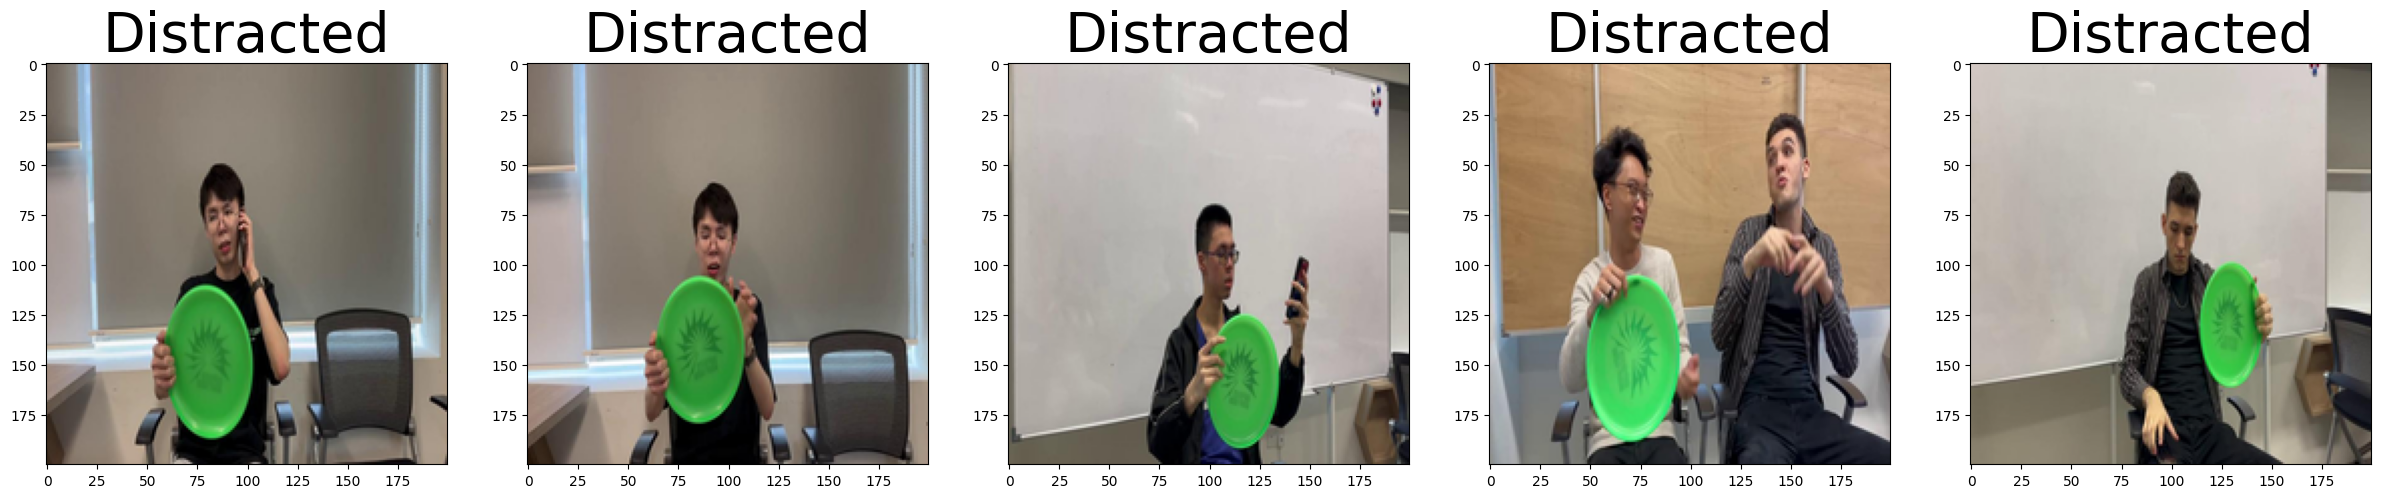

In [28]:
import matplotlib.pyplot as plt
from PIL import Image 
import os
import csv
from math import ceil

DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
DATA_DOWNLOAD_DIR = os.environ.get('DATA_DOWNLOAD_DIR')
csv_path = os.path.join(DATA_DIR, 'split', 'test', 'Distracted', 'result.csv')
results = []
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        results.append((row[0], row[1]))

w,h = 200,200
fig = plt.figure(figsize=(30,30))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns,i)
    img = Image.open(results[i][0].replace(DATA_DOWNLOAD_DIR, DATA_DIR))
    img = img.resize((w,h), Image.ANTIALIAS)
    plt.imshow(img)
    ax.set_title(results[i][1], fontsize=40)

## 10. Export and Deploy! <a class="anchor" id="head-10"></a>

In [29]:
!tao classification_tf1 export \
            -m $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
            -o $USER_EXPERIMENT_DIR/export/final_model.etlt \
            -k $KEY

2023-02-08 12:06:50,537 [INFO] root: Registry: ['nvcr.io']
2023-02-08 12:06:50,595 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 04:06:51.678919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gby2g8tn because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 04:06:55.055532: I tensorflow/core/platform/profile_utils/cpu_utils.c

In [30]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/export/

Exported model:
------------
total 39M
-rw-r--r-- 1 pk-2023-t2 pk_2022-t2 39M Feb  8 12:07 final_model.etlt


### A. Int8 Optimization <a class="anchor" id="head-10-1"></a>
Classification model supports int8 optimization for inference in TRT. In order to use this, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tao <task> export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use at least 10-20% of the training data to calibrate the model.*

In [31]:
!tao classification_tf1 calibration_tensorfile -e $SPECS_DIR/classification_retrain_spec.cfg \
                                    -m 10 \
                                    -o $USER_EXPERIMENT_DIR/export/calibration.tensor

2023-02-08 12:10:09,990 [INFO] root: Registry: ['nvcr.io']
2023-02-08 12:10:10,045 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5
Using TensorFlow backend.
2023-02-08 04:10:11.219450: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vnaeqxm1 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 04:10:14.659588: I tensorflow/core/platform/profile_utils/cpu_utils.c

In [ ]:
# Remove the pre-existing exported .etlt file.
!rm -rf $LOCAL_EXPERIMENT_DIR/export/final_model.etlt
!tao classification_tf1 export \
            -m $USER_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
            -o $USER_EXPERIMENT_DIR/export/final_model.etlt \
            -k $KEY \
            --cal_data_file $USER_EXPERIMENT_DIR/export/calibration.tensor \
            --data_type int8 \
            --batches 10 \
            --cal_cache_file $USER_EXPERIMENT_DIR/export/final_model_int8_cache.bin \
            -v 

### B. Generate TensorRT engine <a class="anchor" id="head-10-2"></a>
Verify engine generation using the `tao-converter` utility included with the docker.

The `tao-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tao-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The tao-converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the tao-converter for jetson from the dev zone link [here](https://developer.nvidia.com/tao-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!tao converter $USER_EXPERIMENT_DIR/export/final_model.etlt \
               -k $KEY \
               -c $USER_EXPERIMENT_DIR/export/final_model_int8_cache.bin \
               -o predictions/Softmax \
               -d 3,224,224 \
               -i nchw \
               -m 64 -t int8 \
               -e $USER_EXPERIMENT_DIR/export/final_model.trt \
               -b 64